<a href="https://colab.research.google.com/github/morgansaras27/MAE598-FinalProject/blob/master/LSTM_GRU_RNA_Degradation_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
''' SET-UP '''
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import re
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Input, Dropout, Bidirectional, Embedding, SpatialDropout1D
import matplotlib.pyplot as plt

''' PRE-PROCESSING FUNCTIONS '''
def load_data(file_train, file_test, file_sub):
    df_train = pd.read_json(file_train, lines=True)
    df_train = df_train.query("signal_to_noise >= 1")
    df_test = pd.read_json(file_test, lines=True)
    test_pub = df_test[df_test["seq_length"] == 107]
    test_pri = df_test[df_test["seq_length"] == 130]
    df_sub = pd.read_csv(file_sub)
    return df_train, df_test, df_sub

def pandas_list_to_array(df):
    """
    Input: dataframe of shape (x, y), containing list of length l
    Return: np.array of shape (x, l, y)
    """
    return np.transpose(np.array(df.values.tolist()), (0, 2, 1))

def preprocess_inputs(df, token2int, cols=['sequence', 'structure', 'predicted_loop_type']):
    return pandas_list_to_array(
        df[cols].applymap(lambda seq: [token2int[x] for x in seq]))

In [3]:
''' LOAD DATA - TRAIN and TEST, PREPROCESS '''
# Note that the files must be downloaded from Kaggle at the link below and uploaded to user's Google Drive
# Kaggle Link: https://www.kaggle.com/c/stanford-covid-vaccine/data
path = 'drive/My Drive/'
file_train = 'train.json'
file_test = 'test.json'
file_sub = 'sample_submission.csv'

df_train, df_test, df_sub = load_data(path+file_train, path+file_test, path+file_sub)

token2int = {x:i for i, x in enumerate('().ACGUBEHIMSX')} #creates vocabulary for model
train_inputs = preprocess_inputs(df_train, token2int) #tokenizes inputs for training
pred_cols = ['reactivity', 'deg_Mg_pH10', 'deg_Mg_50C', 'deg_pH10', 'deg_50C'] #names of output values
train_labels = pandas_list_to_array(df_train[pred_cols]) #creates array of targets
x_train, x_val, y_train, y_val = train_test_split(train_inputs, train_labels, test_size=0.1) #split into train and test sets with 90/10

In [4]:
''' FUNCTIONS FOR MODEL CREATION'''
# Function to create GRU layer
def gru_layer(hidden_dim, dropout):
    return Bidirectional(GRU(hidden_dim, dropout=dropout, 
                             return_sequences=True, 
                             kernel_initializer='orthogonal'))

# Function to create LSTM layer
def lstm_layer(hidden_dim, dropout):
    return Bidirectional(LSTM(hidden_dim, dropout=dropout, 
                             return_sequences=True, 
                             kernel_initializer='orthogonal'))

# Builds model using Tensorflow and Keras
def build_model(n_layers, in_shape, dropout, n_nodes, embed_size, embed_dim, hidden_type):
    inputs = Input(shape = in_shape)
    embed = Embedding(input_dim = embed_size, output_dim=embed_dim)(inputs)
    reshaped = tf.reshape(embed, shape = (-1, embed.shape[1], embed.shape[2]*embed.shape[3]))
    hidden = SpatialDropout1D(dropout)(reshaped)
    for i in range(n_layers):
        if hidden_type == 'LSTM':
            hidden = lstm_layer(n_nodes, dropout)(hidden)
        else:
            hidden = gru_layer(n_nodes, dropout)(hidden)
    truncated = hidden[:, :68]
    output = Dense(5, activation='linear')(truncated)
    model = tf.keras.Model(inputs=inputs, outputs=output)
    return model

# Definition of custom MCRMSE loss function
def MCRMSE(y_true, y_pred):
    colwise_mse = tf.reduce_mean(tf.square(y_true - y_pred), axis=1)
    return tf.reduce_mean(tf.sqrt(colwise_mse), axis=1)


In [5]:
''' DEFINE MODEL PARAMETERS & BUILD, COMPILE, TRAIN MODEL  -- LSTM '''
input_shape = (x_train.shape[1], x_train.shape[2]) #shape is 107,3
n_nodes = 50
n_layers = 1
dropout = 0.2
learn_rate = 0.001
opt = keras.optimizers.Adam(learning_rate=learn_rate)
embed_size = len(token2int)
max_epochs = 500
embed_dim = 200
hidden_type = 'LSTM'
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=10)

model_LSTM = build_model(n_layers, input_shape, dropout, n_nodes, embed_size, embed_dim, hidden_type)
model_LSTM.compile(optimizer=opt, loss=MCRMSE, metrics=[tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.MeanSquaredError()])
print(model_LSTM.summary())

history_LSTM = model_LSTM.fit(x_train, y_train, 
                    epochs=max_epochs, validation_split=0.2, 
                    verbose=0, batch_size=64, 
                    callbacks = [callback]) 

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 107, 3)]          0         
_________________________________________________________________
embedding (Embedding)        (None, 107, 3, 200)       2800      
_________________________________________________________________
tf_op_layer_Reshape (TensorF [(None, 107, 600)]        0         
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 107, 600)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 107, 100)          260400    
_________________________________________________________________
tf_op_layer_strided_slice (T [(None, 68, 100)]         0         
_________________________________________________________________
dense (Dense)                (None, 68, 5)            

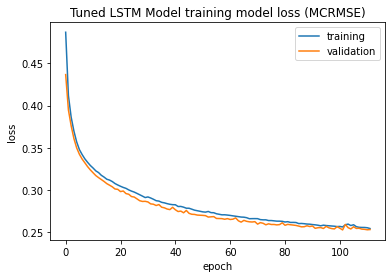

4/4 [==============================] - 0s 8ms/step - loss: 0.2640 - mean_absolute_error: 0.1785 - mean_squared_error: 0.0845
Test results - tuned LSTM (MCRMSE, MAE, MSE): [0.2639859914779663, 0.17854735255241394, 0.08446788787841797]


In [6]:
''' PLOT TRAINING LOSS & TEST TRAINED MODEL -- LSTM '''
# Plot training loss
history = history_LSTM
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Tuned LSTM Model training model loss (MCRMSE)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

#Evaluate the model on the test data using `evaluate`
results_LSTM = model_LSTM.evaluate(x_val, y_val, batch_size=64)
print("Test results - tuned LSTM (MCRMSE, MAE, MSE):", results_LSTM)

# Generate predictions on new data using `predict`
# Note these predictions are plotted later and compared directly to GRU model performance
predictions_LSTM = model_LSTM.predict(x_val)

In [7]:
''' DEFINE MODEL PARAMETERS & BUILD, COMPILE, TRAIN MODEL  -- GRU '''
input_shape = (x_train.shape[1], x_train.shape[2]) #shape is 107,3
n_nodes = 50
n_layers = 3
dropout = 0.2
learn_rate = 0.01
opt = keras.optimizers.Adam(learning_rate=learn_rate)
embed_size = len(token2int)
max_epochs = 500
embed_dim = 200
hidden_type = 'GRU'
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=10)

model_GRU = build_model(n_layers, input_shape, dropout, n_nodes, embed_size, embed_dim, hidden_type)
model_GRU.compile(optimizer=opt, loss=MCRMSE, metrics=[tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.MeanSquaredError()])
print(model_GRU.summary())

history_GRU = model_GRU.fit(x_train, y_train, 
                      epochs=max_epochs, validation_split=0.2, 
                      verbose=0, batch_size=64, 
                      callbacks = [callback])

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 107, 3)]          0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 107, 3, 200)       2800      
_________________________________________________________________
tf_op_layer_Reshape_1 (Tenso [(None, 107, 600)]        0         
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 107, 600)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 107, 100)          195600    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 107, 100)          45600     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 107, 100)         

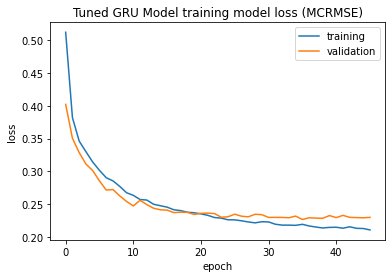

4/4 [==============================] - 0s 16ms/step - loss: 0.2419 - mean_absolute_error: 0.1616 - mean_squared_error: 0.0718
test results - tuned GRU: [0.24191609025001526, 0.1616290658712387, 0.07177060097455978]


In [8]:
''' PLOT TRAINING LOSS & TEST TRAINED MODEL -- GRU '''
# Plot training loss
history = history_GRU
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Tuned GRU Model training model loss (MCRMSE)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

# Evaluate the model on the test data using `evaluate`
results_GRU = model_GRU.evaluate(x_val, y_val, batch_size=64)
print("test results - tuned GRU:", results_GRU)

# Generate predictions on new data using `predict`
# Note these predictions are plotted later and compared directly to LSTM model performance
predictions_GRU = model_GRU.predict(x_val)

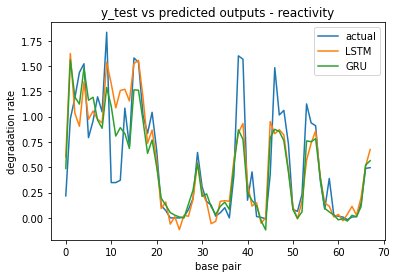

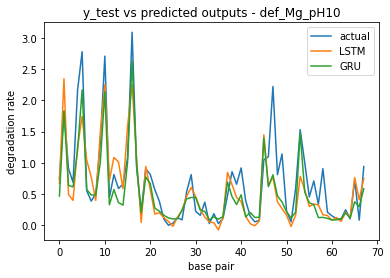

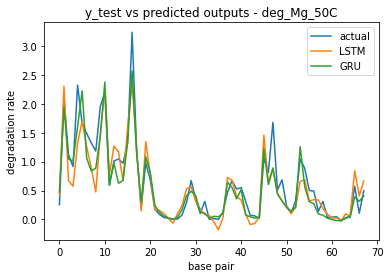

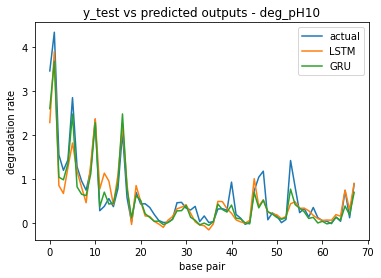

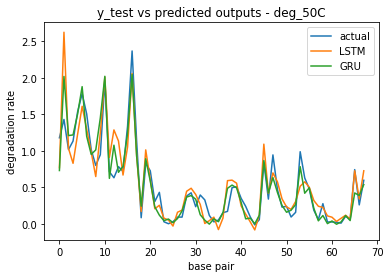

In [9]:
''' PLOT PREDICTED VALUES FOR DEGRADATION RATES FOR ACTUAL vs. LSTM & GRU MODELS '''
# Note only a single sample can be chosen for visualization as an example. 
sample_id = 8

# Output #1 - reactivity
plt.plot(y_val[sample_id,:,0])
plt.plot(predictions_LSTM[sample_id,:,0])
plt.plot(predictions_GRU[sample_id,:,0])
plt.title('y_test vs predicted outputs - reactivity')
plt.ylabel('degradation rate')
plt.xlabel('base pair')
plt.legend(['actual', 'LSTM','GRU'], loc='upper right')
plt.show()

# Output #2 - deg_Mg_pH10
plt.plot(y_val[sample_id,:,1])
plt.plot(predictions_LSTM[sample_id,:,1])
plt.plot(predictions_GRU[sample_id,:,1])
plt.title('y_test vs predicted outputs - def_Mg_pH10')
plt.ylabel('degradation rate')
plt.xlabel('base pair')
plt.legend(['actual', 'LSTM','GRU'], loc='upper right')
plt.show()

# Output #3 - deg_Mg_50C
plt.plot(y_val[sample_id,:,2])
plt.plot(predictions_LSTM[sample_id,:,2])
plt.plot(predictions_GRU[sample_id,:,2])
plt.title('y_test vs predicted outputs - deg_Mg_50C')
plt.ylabel('degradation rate')
plt.xlabel('base pair')
plt.legend(['actual', 'LSTM','GRU'], loc='upper right')
plt.show()

# Output #4 - deg_pH10
plt.plot(y_val[sample_id,:,3])
plt.plot(predictions_LSTM[sample_id,:,3])
plt.plot(predictions_GRU[sample_id,:,3])
plt.title('y_test vs predicted outputs - deg_pH10')
plt.ylabel('degradation rate')
plt.xlabel('base pair')
plt.legend(['actual', 'LSTM','GRU'], loc='upper right')
plt.show()

# Output #5 - deg_50C
plt.plot(y_val[sample_id,:,4])
plt.plot(predictions_LSTM[sample_id,:,4])
plt.plot(predictions_GRU[sample_id,:,4])
plt.title('y_test vs predicted outputs - deg_50C')
plt.ylabel('degradation rate')
plt.xlabel('base pair')
plt.legend(['actual', 'LSTM','GRU'], loc='upper right')
plt.show()